In [43]:
import os
import pandas as pd
import pyarrow as pa

from deltalake import DeltaTable
from deltalake.writer import write_deltalake

import yfinance as yf

import warnings

## **Example 1:** TimeVariant datasets

In [5]:
option = "writelake"

In [7]:
delta_directory = os.path.join("tmp", option)
deltalake_name = os.path.join(delta_directory, "eq_prices")

In [276]:
# pd.options.display.float_format = '{:,.4f}'.format

In [154]:
dfs = []
for sector in ["consumer-cyclical", "technology", "energy", "financial-services"]:
    df = yf.Sector(sector).top_companies
    df["sector"] = sector
    dfs.append(df)

df_sectors = pd.concat(dfs)    

In [326]:
# tickers = ['AAPL', 'MSFT', 'GOOGL']

tickers = df_sectors.index.tolist()

data = yf.download(tickers, start='2020-01-01', end='2025-01-03')
df = data.stack(future_stack=True).reset_index()
df.columns = [i for i in df.columns.values]
df.columns = [col.lower() for col in df.columns]
df["date"] = pd.to_datetime(df["date"])
df.set_index("date", inplace=True)
df.sort_index(ascending=True, inplace=True)

[*********************100%***********************]  200 of 200 completed


In [327]:
# Data consistency
# find tickers where we don't have any price
def all_col_empty(grp):
    cols = grp.columns[grp.isna().any()].tolist()
    if len(cols)==0:
        return None
    else:
        return ", ".join(cols)

df_grp = df.groupby("ticker").apply(lambda grp: all_col_empty(grp)).reset_index()
empty_tickers = df_grp[df_grp[0].notnull()]["ticker"].tolist()

df["ticker_has_sufficient_info_result"] = ~df["ticker"].isin(empty_tickers)

In [328]:
# We only keep the tickers where we have sufficient info to perform QC
df = df[df["ticker_has_sufficient_info_result"]]
df_missing_data = df[~df["ticker_has_sufficient_info_result"]]

In [329]:
# QC on Close price
warnings.simplefilter('ignore')
df["close_is_in_range_test"] = "close >= low and close <= high"
df["close_is_in_range_columns"] = "close, low, high"
df["close_is_in_range_result"] = (df["close"].round(5) >= df["low"].round(5)) & (df["close"].round(5)<= df["high"].round(5))


In [330]:
# We only keep the tickers where the obivous check passed
df = df[df["close_is_in_range_result"]]
df_inconsistent = df[~df["close_is_in_range_result"]]

In [331]:
# df1 = df.query("index == '2021-12-28' and ticker=='PAA'")

In [332]:
df["close_shift"] = df.groupby("ticker")["close"].shift(1)
df["close_shift"].fillna(df["close"], inplace=True)
df["day_over_day_chge"] = (df["close"] - df["close_shift"]) / df["close_shift"]
window = 60
df["simple_moving_avg"] = df.groupby("ticker")["close"].transform(lambda d: d.rolling(window, min_periods=1).mean())
df["simple_moving_std"] = df.groupby("ticker")["close"].transform(lambda d: d.rolling(window, min_periods=1).std())
df["simple_zscore"] = (df["close"] - df["simple_moving_avg"])/df["simple_moving_std"]
df["simple_zscore_test"] = "simple_zscore within abs(3)"
df["simple_zscore_columns"] = "close, simple_moving_avg, simple_moving_std, simple_zscore"
df["simple_zscore_result"] = (df["simple_zscore"] > -3) & (df["simple_zscore"] < 3)

In [350]:
# The ticker with the simple zscore are considered as QCed - "Good to go"
df = df[df["simple_zscore_result"]]
df_zscore_failed = df[~df["simple_zscore_result"]]
# confirmed that the below line would return no details
# df[(df["simple_zscore_result"]) & (~df["exp_zscore_result"])].tail()

In [352]:
df["exp_moving_avg"] = df.groupby("ticker")["close"].transform(lambda d: d.ewm(span=window).mean())
df["exp_moving_std"] = df.groupby("ticker")["close"].transform(lambda d: d.ewm(span=window).std())
df["exp_zscore"] = (df["close"] - df["exp_moving_avg"])/df["exp_moving_std"]
df["exp_zscore_test"] = "exp_zscore within abs(3)"
df["exp_zscore_columns"] = "close, exp_zscore_avg, exp_zscore_std, exp_zscore"
df["exp_zscore_result"] = (df["exp_zscore"] > -3) & (df["exp_zscore"] < 3)

In [354]:
# The ticker with the simple zscore are considered as QCed - "Good to go"
df = df[df["exp_zscore_result"]]
df_zscore_failed_2 = df[~df["exp_zscore_result"]]

In [356]:
df.shape

(226471, 24)

In [362]:
df_zscore_failed

,ticker,close,high,low,open,volume,ticker_has_sufficient_info_result,close_is_in_range_test,close_is_in_range_columns,close_is_in_range_result,...,simple_zscore,simple_zscore_test,simple_zscore_columns,simple_zscore_result,exp_moving_avg,exp_moving_std,exp_zscore,exp_zscore_test,exp_zscore_columns,exp_zscore_result
date,,,,,,,,,,,,,,,,,,,,,


In [306]:
check_tickers = df_sectors[df_sectors["sector"]=="consumer-cyclical"].index.tolist()

<Axes: xlabel='date'>

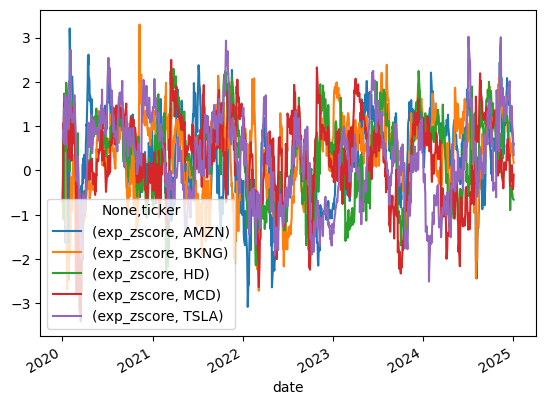

In [314]:
df[df["ticker"].isin(check_tickers[:5])].reset_index().pivot_table(values=["exp_zscore"], 
                                                 columns=["ticker"], index=["date"]).plot()

<Axes: xlabel='date'>

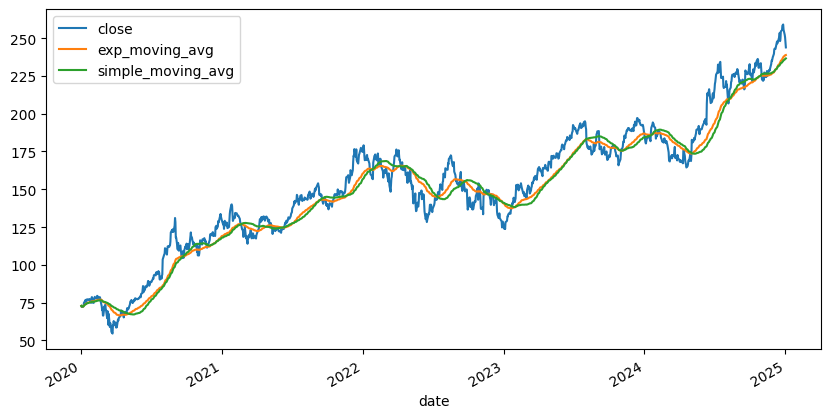

In [316]:
df[df["ticker"]=="AAPL"][["close", "exp_moving_avg", "simple_moving_avg"]].plot(figsize=(10,5))